In [1]:
import os
import sys
srcpath = os.path.realpath('../SourceFiles')
sys.path.append(srcpath)
import pyte_visa_utils as pyte

In [2]:
%matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
from IPython.core.debugger import set_trace
from scipy.signal import chirp, sweep_poly
import matplotlib.pyplot as plt

# Digitizer Signal Self Trigger

This script uses the Digitizer in a benchtop or desktop unit with self Trigger mode.<br>
    
The Signal generator is configured:<br>
DAC frequency: `2GHz`<br>

Channel 1:<br>
 - Sine waveform;  
 - amplitude 0.7V; 
 
Channel 2:<br>  
 - Triangular waveform;  
 - amplitude 0.7V;  
          
CH1 should be connected to Digitizer channel 1.<br>
CH2 should be connected to Digitizer channel 2.<br>

The Digitizer is configured:
 - Mode           : SINGLE 
 - Sample Rate    : 2GHz
 - Trigger source : CH1 (Channel 1 self trigger)
 - The Digitizer External Trigger threshold is set to 0.7V

This script uses 4 Frames with 4800 samples each.<br>

Start the Digitizer;<br>
 - wait for the status done bit goes back to 'high'.<br><br>
 
Stop the Digitizer;<br>

Read the DDR memory and plot the signals.<br>

check the proteus registers and close the script.<br>


In [3]:
# Connect to instrument

# Please choose appropriate address:
inst_addr = 'TCPIP::172.16.10.1::5025::SOCKET'

print('Connecting ..')
inst = pyte.open_session(inst_addr)
resp = inst.query("*IDN?")
print('Connected to: ' + resp)

Connecting ..
Connected to: Tabor Electronics,P2584M,000000220725,1.115.0


In [4]:
# Paranoia Level (0: low, 1: normal, 2: debug)
paranoia_level = 2

# Get the instrument's *IDN
resp = inst.query('*IDN?')
print(resp)

# Get the DAC mode (8 bits or 16 bits)
resp = inst.query(':SYST:INF:DAC?')

if resp == 'M0': 
    dac_mode=16 
else: dac_mode=8

print('DAC {0} bits'.format(dac_mode))

if dac_mode == 16:
    max_dac = 65535
    data_type = np.uint16 
else:
    max_dac = 255
    data_type = np.uint8 
    
half_dac = max_dac / 2.0

# Several initializations ..
pyte.send_cmd(inst,'*CLS; *RST', paranoia_level)
pyte.send_cmd(inst,':INST:CHAN 1', paranoia_level)
pyte.send_cmd(inst,':SOUR:FREQ 2.0e9', paranoia_level)
pyte.send_cmd(inst,':TRAC:DEL:ALL', paranoia_level)
resp = inst.query(':SYST:ERR?')
print(resp)

Tabor Electronics,P2584M,000000220725,1.115.0
DAC 16 bits
0, no error


## Configure Generator

In [5]:
# data-type code: 'B' = uint8, 'H' = uint16
wav_dat_type = 'H' if dac_mode == 16 else 'B'


# Build two AWG segment that will be used as innput for the digitizer
cycleLen = 1024
numCycles = 8
segLen = cycleLen * numCycles

# Build waveform (sine wave)
x = np.linspace(
    start=0, stop=2 * np.pi * numCycles, num=segLen, endpoint=False)

y = (np.sin(x) + 1.0) * half_dac
y = np.round(y)
y = np.clip(y, 0, max_dac)
y = y.astype(data_type)

# download it to segment 2 of channel 1
pyte.send_cmd(inst,':INST:CHAN 1', paranoia_level)
pyte.send_cmd(inst,':TRAC:DEF 1,' + str(segLen), paranoia_level)
pyte.send_cmd(inst,':TRAC:SEL 1', paranoia_level)
pyte.send_cmd(inst,':SOUR:FUNC:MODE:SEGM 1', paranoia_level)
pyte.send_cmd(inst,':SOUR:VOLT 0.4', paranoia_level)
pyte.send_cmd(inst,':OUTP ON', paranoia_level)
# download the waveform to the selected segment
inst.write_binary_values('*OPC?; :TRAC:DATA', y, datatype=wav_dat_type)

# Read the response to the *OPC? query that was added to the prefix of the binary data
resp = inst.read()
    
    
resp = inst.query(':SYST:ERR?')
print(resp)

y = np.sin(x)
y = np.arcsin(y)* 2 * half_dac / np.pi + half_dac
y = np.round(y)
y = np.clip(y, 0, max_dac)
y = y.astype(data_type)

# download it to segment 2 of channel 1
pyte.send_cmd(inst,':INST:CHAN 2', paranoia_level)
pyte.send_cmd(inst,':TRAC:DEF 2,' + str(segLen), paranoia_level)
pyte.send_cmd(inst,':TRAC:SEL 2', paranoia_level)
pyte.send_cmd(inst,':SOUR:FUNC:MODE:SEGM 2', paranoia_level)
pyte.send_cmd(inst,':SOUR:VOLT 0.4', paranoia_level)
pyte.send_cmd(inst,':OUTP ON', paranoia_level)
# download the waveform to the selected segment
inst.write_binary_values('*OPC?; :TRAC:DATA', y, datatype=wav_dat_type)

# Read the response to the *OPC? query that was added to the prefix of the binary data
resp = inst.read()

resp = inst.query(':SYST:ERR?')
print(resp)

0, no error
0, no error


## Setup Digitizer

In [6]:
# Setup the digitizer in two-channels mode
pyte.send_cmd(inst,':DIG:MODE SING', paranoia_level)
pyte.send_cmd(inst,':DIG:FREQ 2000e6', paranoia_level)

# Enable capturing data from channel 1
pyte.send_cmd(inst,':DIG:CHAN CH1', paranoia_level)
pyte.send_cmd(inst,':DIG:CHAN:STAT ENAB', paranoia_level)
# Select the external-trigger as start-capturing trigger:
pyte.send_cmd(inst,':DIG:TRIG:SOUR CH1', paranoia_level)
pyte.send_cmd(inst,':DIG:TRIG:SELF:LEV -0.1', paranoia_level)


# Allocate four frames of 4800 samples
numframes, framelen = 4, 4800
cmd = ':DIG:ACQuire:FRAM:DEF {0},{1}'.format(numframes, framelen)
pyte.send_cmd(inst,cmd, paranoia_level)

# Select the frames for the capturing 
# (all the four frames in this example)
capture_first, capture_count = 1, numframes
cmd = ":DIG:ACQ:FRAM:CAPT {0},{1}".format(capture_first, capture_count)
pyte.send_cmd(inst,cmd, paranoia_level)

# Clean memory 
pyte.send_cmd(inst,':DIG:ACQ:ZERO:ALL', paranoia_level)

resp = inst.query(':SYST:ERR?')
print(resp)
print("Set Digitizer: DUAL mode; internal Trigger")


0, no error
Set Digitizer: DUAL mode; internal Trigger


#### Acquire signals into Memory

In [7]:
# Stop the digitizer's capturing machine (to be on the safe side)
pyte.send_cmd(inst,':DIG:INIT OFF', paranoia_level)

# Start the digitizer's capturing machine
pyte.send_cmd(inst,':DIG:INIT ON', paranoia_level)

print('Waiting for status done bit ..')
loopcount = 0
done = 0
while done == 0:
    resp = inst.query(":DIG:ACQ:FRAM:STATus?")
    resp_items = resp.split(',')
    done = int(resp_items[1])
    print("{0}. {1}".format(done, resp_items))
    loopcount += 1
    if loopcount == 10:
        print("No Trigger was detected")
        done = 1  
print("Capture Done")

# Stop the digitizer's capturing machine (to be on the safe side)
pyte.send_cmd(inst,':DIG:INIT OFF', paranoia_level)

resp = inst.query(':SYST:ERR?')
print(resp)
print("Digitizer: Finish Acquisition")

Waiting for status done bit ..
1. ['1', '1', '0', '4']
Capture Done
0, no error
Digitizer: Finish Acquisition


#### Read all frames from Memory

In [8]:
# Choose which frames to read (all in this example)
pyte.send_cmd(inst,':DIG:DATA:SEL ALL', paranoia_level)

# Choose what to read 
# (only the frame-data without the header in this example)
pyte.send_cmd(inst,':DIG:DATA:TYPE FRAM', paranoia_level)

# Get the total data size (in bytes)
resp = inst.query(':DIG:DATA:SIZE?')
num_bytes = np.uint32(resp)
print('Total size in bytes: ' + resp)
print()

# Read the data that was captured by channel 1:
pyte.send_cmd(inst,':DIG:CHAN:SEL 1', paranoia_level)

wavlen = num_bytes // 2

wav1 = np.zeros(wavlen, dtype=np.uint16)

wav1 = inst.query_binary_values(':DIG:DATA:READ?', datatype='H', is_big_endian=False)

## Read the data that was captured by channel 2:
#pyte.send_cmd(inst,':DIG:CHAN:SEL 2', paranoia_level)
#
#wavlen = num_bytes // 2
#
#wav2 = np.zeros(wavlen, dtype=np.uint16)
#
#wav1 = inst.query_binary_values(':DIG:DATA:READ?', datatype='H', is_big_endian=False)

resp = inst.query(':SYST:ERR?')
print(resp)
print("read data from DDR")


Total size in bytes: 38400

0, no error
read data from DDR


## Plot Signals

<IPython.core.display.Javascript object>


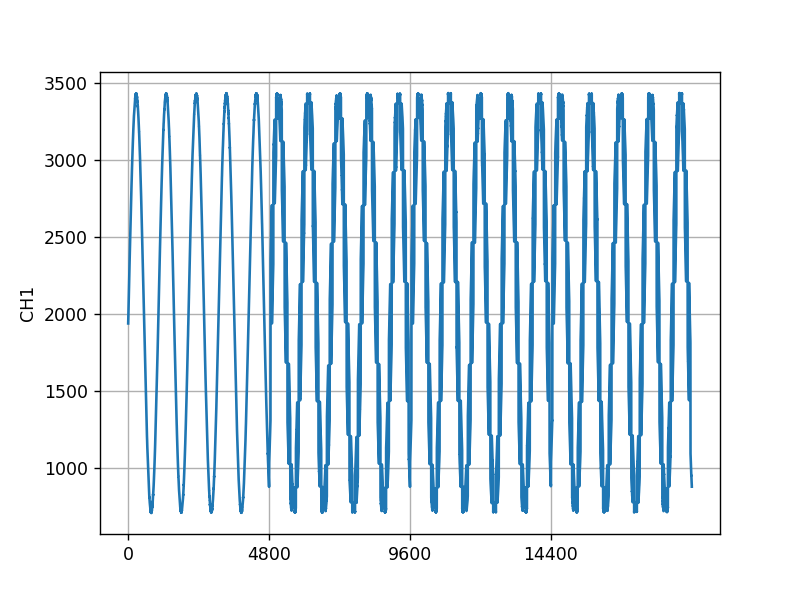

In [9]:
# Plot the samples
totlen = numframes * framelen
x = range(numframes * framelen)
plt.figure(1)
ax1 = plt.subplot(111)
ax1.set_xticks(np.arange(0, totlen, framelen))
ax1.grid(True)
ax1.plot(x, wav1)
ax1.set_ylabel('CH1')


plt.show()


## End

In [12]:
# close connection
inst.close

<bound method Resource.close of <'TCPIPSocket'('TCPIP::172.16.10.1::5025::SOCKET')>>